# CSCI 5922 (Spring 2020) Final Project
name: Timothy Mason
***
Music Genre classification using a CRNN as described in the paper blah, blah, blah...

todo: fill in citations and flesh out overview

In [1]:
import os
import numpy as np
import pandas as pd
from pathlib import Path
from tqdm import tqdm      # for easy and attractive progress bars

import hdf5_getters        # https://github.com/tbertinmahieux/MSongsDB/tree/master/PythonSrc
# hdf5_getters.py is Copyright 2010, Thierry Bertin-Mahieux
# This program is free software: you can redistribute it and/or modify
# it under the terms of the GNU General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.

## Functions for importing data

In [2]:
# see http://docs.echonest.com.s3-website-us-east-1.amazonaws.com/_static/AnalyzeDocumentation.pdf for
# detailed discussion of the category data items
def hdf_tree_to_dataframe(msd_path='./MillionSongSubset/data',
                          categories={"artist_name",          # Name of the artist
                                      "release",              # Album name
                                      "title",                # Title of the piece
                                      "year",                 # year released (unreliable - often 0)
                                      "analysis_sample_rate", # sample rate (Hz) for the analysis
                                      "duration",             # length of the piece (seconds)
                                      "tempo",                # tempo of the piece (avg beats per minute)
                                      "beats_start",          # list of time markers (seconds) for beats
                                      "bars_start",           # list of time markers (seconds) for bars
                                      "tatums_start",         # "list of tatum markers, in seconds. Tatums 
                                                              # represent the lowest regular pulse train that
                                                              # a listener intuitively infers from the timing
                                                              # of perceived musical events (segments)."
                                      "segments_start",       # list of time markers (seconds) for segments
                                      "segments_pitches",     # list of 12-ary vectors, each contains relative
                                                              # strength of the notes (pitches) contained in 
                                                              # a segment.  0 = strength(0..1) of the C note, 
                                                              # 1 = strength of C-sharp, 
                                                              # ... 
                                                              # 11 = B
                                      "segments_timbre",      # list of 12-ary vectors, "timbre is the quality
                                                              # of a musical note or sound that distinguishes 
                                                              # different types of musical instruments, or 
                                                              # voices. It is a complex notion also referred 
                                                              # to as sound color, texture, or tone quality, 
                                                              # and is derived from the shape of a segment’s 
                                                              # spectro-temporal surface, independently of 
                                                              # pitch and loudness. "
                                     }, 
                          first = 0, last = None):
    """
    Walk the directory structure of the provided path, and read data from the
    *.h5 files in all subdirectories.

    Parameters
    ----------
    categories: set of keyword strings.  Note:  'track_id' is the index field, so it will always read
        that category, whether it is specified or not.
    msd_path: The path to the root directory of the MSD dataset
    first: Index of the first file to read
    last: Index of the last file to read.  If None, then read entire list of files

    Returns
    -------
    a Pandas dataframe object containing the specified categories of MSD data
    """

    categories.add('track_id')   # categories is type "set", so no worry about duplicates

    file_list = [f for f in Path(msd_path).glob('**/*.h5')]

    if last == None:
        last = len(file_list)
    data = []

    for f in tqdm(file_list[first:last], desc=f"Loading Million Song Subset"):
        h5file = hdf5_getters.open_h5_file_read(f)
        d = {}
        for c in categories:
            t = getattr(hdf5_getters, "get_"+c)(h5file)
            d[c] = t
        h5file.close()
        data.append(d)
    return pd.DataFrame(data).set_index('track_id')

def json_tree_to_dataframe( lfm_path='./lastfm_subset' ):
    """
    Load the data from all JSON files at the specified directory and its' subdirectories
    into a Pandas DataFrame
    
    Parameters
    ----------
    lfm_path: The path to the root directory of the last.fm dataset

    Returns
    -------
    a Pandas DataFrame object containing the entire dataset
    """
    
    # Appending one record at a time to a Pandas DataFrame is inefficient, so build a simple list
    # in memory, then create the Pandas DataFrame in one shot from that list
    data = []
    for file_path in tqdm([f for f in Path(lfm_path).glob('**/*.json')], desc="Loading JSON data"):
        with open(file_path) as json_data:     # with... syntax benefits from automatic file closing
            data.append(json.load(json_data))
            
    return pd.DataFrame(data).set_index('track_id')


### Test code for data loaders

In [3]:
msd_df = hdf_tree_to_dataframe()
msd_df

Loading Million Song Subset: 100%|██████████| 10000/10000 [06:47<00:00, 24.56it/s]


,duration,artist_name,year,segments_start,bars_start,release,tempo,segments_timbre,analysis_sample_rate,title,beats_start,tatums_start,segments_pitches
track_id,,,,,,,,,,,,,
TRARRZU128F4253CA2,148.74077,Raphaël,2008,"[0.0, 0.19188, 0.60499, 0.84939, 1.10018, 1.36...","[0.52458, 2.4444, 4.3658, 6.30006, 8.22086, 10...",Je Sais Que La Terre Est Plate (Deluxe),124.059,"[[0.0, 171.13, 9.469, -28.48, 57.491, -50.067,...",22050,Je Sais Que La Terre Est Plate,"[0.04257, 0.52458, 1.00659, 1.48632, 1.96605, ...","[0.04257, 0.28357, 0.52458, 0.76558, 1.00659, ...","[[0.726, 0.112, 0.02, 0.019, 0.01, 0.038, 0.03..."
TRARRJL128F92DED0E,252.99546,Julie Zenatti,2004,"[0.0, 0.51379, 0.89138, 1.30912, 1.65297, 2.05...","[8.69527, 12.01758, 14.81363, 20.09003, 22.693...",Comme Vous,80.084,"[[0.008, 170.986, 9.126, -28.685, 57.183, -50....",22050,On Efface,"[0.59161, 1.33555, 2.07949, 2.82093, 3.56238, ...","[0.59161, 0.84042, 1.08799, 1.33555, 1.58436, ...","[[0.943, 1.0, 0.91, 0.782, 0.726, 0.806, 0.314..."
TRARRUZ128F9307C57,78.02730,The Baltimore Consort,0,"[0.0, 0.97365, 1.34431, 1.81351, 2.19764, 2.44...","[1.95344, 6.35701, 10.70579, 15.07913, 19.4832...",Watkins Ale - Music of the English Renaissance,54.874,"[[1.337, 145.247, -43.274, -47.807, 18.519, -4...",22050,Howells Delight,"[1.95344, 3.0622, 4.16548, 5.26467, 6.35701, 7...","[1.11537, 1.39701, 1.67864, 1.95344, 2.23097, ...","[[1.0, 0.926, 0.264, 0.384, 0.298, 0.261, 0.22..."
TRARRWA128F42A0195,163.63057,I Hate Sally,2007,"[0.0, 0.07306, 0.36862, 0.64739, 0.79238, 1.04...","[0.39309, 2.75109, 5.13649, 7.52978, 9.95582, ...",Don't Worry Lady,77.150,"[[14.832, -56.33, 69.981, -43.028, 138.861, 58...",22050,Martha Served,"[0.39309, 1.17222, 1.95902, 2.75109, 3.55236, ...","[0.11929, 0.39309, 0.65603, 0.91083, 1.17222, ...","[[0.835, 0.639, 0.492, 0.399, 0.326, 0.697, 0...."
TRARRPG12903CD1DE9,199.99302,Orlando Pops Orchestra,0,"[0.0, 0.3166, 0.82195, 1.2751, 1.80871, 2.3314...","[0.99301, 2.99441, 4.96889, 6.9402, 8.92127, 1...",Easy Listening: Cartoon Songs,120.382,"[[10.095, 38.901, 84.505, -190.87, 59.787, 25....",22050,Zip-A-Dee-Doo-Dah (Song of the South),"[0.49266, 0.99301, 1.49336, 1.99371, 2.49406, ...","[0.24248, 0.49266, 0.74283, 0.99301, 1.24318, ...","[[0.014, 0.014, 0.246, 0.037, 0.078, 0.322, 0...."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
TRBBWSE128F9313963,237.16526,Brent Lamb,0,"[0.0, 0.66499, 0.85628, 1.09424, 1.29524, 1.51...","[1.11226, 2.79519, 4.47661, 6.15559, 7.83567, ...",Reflections Of A Simple Man,142.978,"[[12.021, 129.011, 98.485, -308.168, 44.077, -...",22050,One About Heaven,"[0.68993, 1.11226, 1.53496, 1.95554, 2.37483, ...","[0.48105, 0.68993, 0.90092, 1.11226, 1.32361, ...","[[0.583, 0.552, 0.338, 0.294, 0.192, 0.244, 0...."
TRBBWDJ128F42595D5,142.23628,U2,1981,"[0.0, 0.09569, 0.20599, 0.4327, 0.76898, 1.674...","[1.15163, 3.76901, 6.32095, 8.86167, 11.40316,...",October,94.838,"[[24.978, 129.582, 102.42, -99.22, 65.22, 167....",22050,October,"[0.47001, 1.15163, 1.80581, 2.46279, 3.13142, ...","[0.1306, 0.47001, 0.81449, 1.15163, 1.49045, 1...","[[0.611, 0.703, 0.542, 0.747, 0.568, 0.662, 0...."
TRBBWNS128F426F760,346.51383,ZO2,2007,"[0.0, 0.2351, 0.72912, 0.94317, 1.27891, 1.761...","[0.30399, 3.66669, 6.9663, 10.43969, 14.00911,...",Ain't It Beautiful,88.344,"[[0.0, 171.13, 9.469, -28.48, 57.491, -50.067,...",22050,Comin' Home,"[0.30399, 0.98051, 1.6587, 2.34353, 3.02337, 3...","[0.30399, 0.6381, 0.98051, 1.31629, 1.6587, 1....","[[1.0, 0.721, 0.521, 0.492, 0.384, 0.673, 0.56..."


In [4]:
lfm_df = json_tree_to_dataframe()
lfm_df

Loading JSON data: 100%|██████████| 9330/9330 [00:04<00:00, 2091.93it/s]


,artist,timestamp,similars,tags,title
track_id,,,,,
TRARRUZ128F9307C57,The Baltimore Consort,2011-08-09 02:26:16.006819,"[[TRGGBUV128F930B5F6, 1], [TRKJAYK128F930B613,...",[],Howells Delight
TRARROY128F42281F7,Inoki,2011-08-12 06:16:07.401314,[],[],Nuovi Re pt. I I (feat. Tek money - Lady Tambler)
TRARRER128F9328521,Brand X,2011-08-16 01:14:56.584244,"[[TREFJNN128F9328534, 1], [TRGSMOL128F932851A,...","[[chill, 100], [Fusion, 100]]",Liquid Time (composition by John Goodsall)
TRARRVB128F92F47CA,Brigada Victor Jara,2011-08-03 06:41:17.979755,[],[],Parto em terras distantes
TRARRZU128F4253CA2,Raphaël,2011-09-07 04:43:54.487332,[],"[[on the road, 100], [Titletracks, 100]]",Je sais que la terre est plate
...,...,...,...,...,...
TRBBWIP128F4287400,Eddie,2011-08-11 23:14:36.307501,"[[TRMDWBC12903CA42FA, 1], [TRSRAMT12903CA42F8,...","[[pernambuco, 100], [brasil, 62], [brazil, 50]...",Pode me Chamar
TRBBWSE128F9313963,Brent Lamb,2011-08-12 12:26:41.129909,[],[],One About Heaven
TRBBWNS128F426F760,ZO2,2011-08-04 16:48:52.972423,"[[TRFXMIK128F426F751, 1], [TRBWUAQ128F426F74E,...",[],Comin' Home


In [7]:
msd_df.shape[0]

10000

### Sample Data Visualization

Plotting Pitch and Timbre heatmaps:   0%|          | 0/1 [00:00<?, ?it/s]

### TRAJESP12903CBC0B0: "Wonderful Peace" by *Dino* on *Quiet Time*

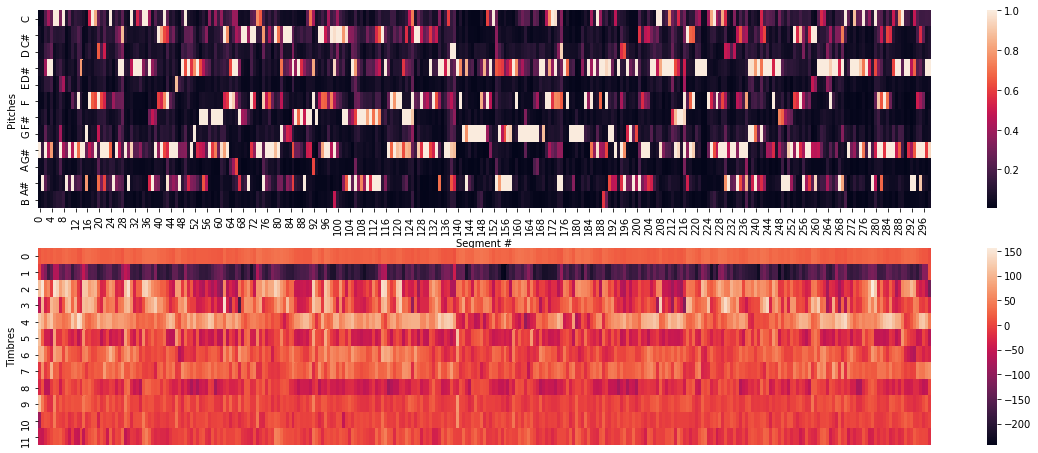

Plotting Pitch and Timbre heatmaps: 100%|██████████| 1/1 [00:01<00:00,  1.28s/it]


In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, Markdown
import random

%matplotlib inline

x = random.randint(0,msd_df.shape[0]-2)

for i in tqdm(msd_df.index[x:x+1], desc="Plotting Pitch and Timbre heatmaps"):
    name = f'### {i:2}: "{msd_df.title[i]}" by *{msd_df.artist_name[i]}* on *{msd_df.release[i]}*'
    if msd_df.year[i] != 0:
        name += f', released {msd_df.year[i]}'
    display(Markdown(name))
    
    # plot a scatterplot of the segment starts
    plt.figure(figsize=(20,8))

    # plot a heatmap of the pitch data
    plt.subplot(2,1,1)
    ax = sns.heatmap(msd_df.segments_pitches[i].T, 
                     yticklabels=("C", "C#", "D", "D#", "E", "F", "F#", "G",
                                 "G#", "A", "A#", "B")
                    )
    ax.set(ylabel="Pitches")
    ax.set(xlabel="Segment #")

    # plot a heatmap of the timbre data
    plt.subplot(2,1,2)
    ax = sns.heatmap(msd_df.segments_timbre[i].T, xticklabels=False)
    ax.set(ylabel="Timbres")
    plt.show()
    plt.close()
    

In [ ]:

xticklabels